In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#Use "-1" for CPU-only devices

#If working on GPU enviroment
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#Limit the memory allocated by tensorflow to only the necessary amount

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
from numpy.random import seed
seed(18)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed
set_seed(18)
set_random_seed(18)

import keras

import matplotlib.pyplot as plt

from Supporting_func_file import *

Version_check()

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


All packages are using the targeted versions.


## Preparing the data
#### Loading the 30,000 measured samples

In [3]:
file_path = "Data_sets/Performance_evaluation/Performance_evaluation_50_ms_data.npz"

fiber_bundle_counts, input_states_rho = Load_data_file(file_path)

print("Shapes")
print("Count distribution of 7 detectors:           ", fiber_bundle_counts.shape)
print("Corresponding coherence matrices:            ", input_states_rho.shape)

Shapes
Count distribution of 7 detectors:            (30000, 7)
Corresponding coherence matrices:             (30000, 2, 2)


#### Generating the mixed state samples

In [4]:
number_of_repetitions = 20
#The created dataset will consists of (number_of_repetitions * 30000) generated mixed data covering the whole Bloch sphere

radial_positions = Radius_dist((number_of_repetitions, input_states_rho.shape[0]))
#Supporting variable for generating mixed states

data_rhos, data_counts = Generate_mixed_dataset(input_states_rho, fiber_bundle_counts, radial_positions)
#Dataset of coherence matrices (data_rhos) with corresponding count distributions (data_counts) generated from the 30,000 measured samples

#### Pre-processing the data for the neural network

In [5]:
data_in = Probability_norm(data_counts)
#Network inputs are the count distributions of the polarization state normed to represent the relative frequencies of the 7 detection channels. I.e., for first polarization state, sum(data_in[0,:7]) = 1.

data_out = Tau_to_Flat(np.linalg.cholesky(data_rhos))
#Network outputs is the "Tau" Cholesky decomposition (in a NN-friendly version "Flat") of the coherence matrix Rho.

#Example to explain the data form
print("First coherency matrix:")
print(data_rhos[0].round(3))
print("")
print("Its Cholesky decomposition in the form of a triangular matrix, Tau:")
print(np.linalg.cholesky(data_rhos[0]).round(3))
print("")
print("The 4 real-valued elements of the Cholesky decomposition, Flat:")
print(data_out[0].round(3))

First coherency matrix:
[[0.497+0.j   0.303-0.31j]
 [0.303+0.31j 0.503-0.j  ]]

Its Cholesky decomposition in the form of a triangular matrix, Tau:
[[0.705+0.j    0.   +0.j   ]
 [0.43 +0.439j 0.354+0.j   ]]

The 4 real-valued elements of the Cholesky decomposition, Flat:
[0.705 0.43  0.439 0.354]


In [6]:
#Randomly shuffling the dataset. Keeping the position relevance. I.e., data_in[i] corresponds to data_out[i] after shuffle.
seed(18)
np.random.shuffle(data_in)
seed(18)
np.random.shuffle(data_out)

In [7]:
#Separating the dataset into training, validation, and test set
first_borderline = (number_of_repetitions+1) * 16000
second_borderline = (number_of_repetitions+1) * 24000

#train_in = data_in[:first_borderline]
#train_out = data_out[:first_borderline]
#Training set was used to train the network

#val_in = data_in[first_borderline:second_borderline]
#val_out = data_out[first_borderline:second_borderline]
#Validation set was used to optimize the network

test_in = data_in[second_borderline:]
test_out = data_out[second_borderline:]
#Test set is used now to evaluate the performance

#print("Number of training data:  ", train_in.shape)
#print("Number of validation data:", val_in.shape)
print("Number of test data:      ", test_in.shape)

Number of test data:       (96000, 7)


## Evaluating models

We randomly generated combinations of channel subsets for each number of active channels in the 'Number of detection channels' graph. <br>
Each subset was used to train a neural network, which was saved after training and is stored in "Trained_models/Number_of_channels" folder.

In [8]:
used_channel_combinations = np.load("Used_channel_combinations.npy", allow_pickle=True)
used_channel_combinations.tolist()

[[0, 1, 2, 3, 4, 5, 6],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 5, 6],
 [0, 1, 2, 4, 5, 6],
 [0, 1, 3, 4, 5, 6],
 [0, 2, 3, 4, 5, 6],
 [0, 1, 2, 3, 5],
 [0, 1, 2, 4, 5],
 [0, 1, 2, 4, 6],
 [0, 2, 3, 4, 6],
 [1, 3, 4, 5, 6],
 [0, 2, 3, 4],
 [1, 2, 3, 4],
 [1, 2, 4, 5],
 [2, 3, 4, 5],
 [2, 4, 5, 6],
 [0, 2, 6],
 [1, 2, 3],
 [1, 2, 4],
 [1, 3, 5],
 [3, 5, 6],
 [0, 3],
 [1, 5],
 [2, 4],
 [3, 6],
 [4, 6]]

For example, the third row [0, 1, 2, 3, 5, 6] contains all number from 0 to 6 except for 4. That means, that this particular combination uses six out of seven channels, not using the channel on position 4. <br>
In the similar fashion, [1, 2, 3] uses three out of seven channels, leaving [0,4,5,6] inactive.

In [9]:
def Evaluate_particular_model(current_channel_comb_):
    current_model = load_model("Trained_models/Number_of_Channels/Channels_dependency_" + str(current_channel_comb_) + "_channels.h5", 
                               custom_objects={"fidelity_metric": fidelity_metric})
    
    current_test_in_subset = Probability_norm(test_in[:, current_channel_comb_])            #Restricting the test set to the current channel subset combination used by the network
    
    pred_test_rho = Flat_to_Density(current_model.predict(current_test_in_subset))          #Predicted polarization states in the form of coherence matrices
    true_test_rho = Flat_to_Density(test_out)                                               #The targeted coherence matrices
    
    test_fidelity_array = Fidelity(true_test_rho, pred_test_rho)
    #The fidelities between predicted and targeted coherence matrices
    
    return test_fidelity_array

Evaluate each network and store their fidelities of test set predictions.

In [10]:
fidelity_arrays = np.zeros([used_channel_combinations.shape[0], test_in.shape[0]])

for i in range(used_channel_combinations.shape[0]):
    print("Network", i+1, "out of", used_channel_combinations.shape[0])
    current_channel_comb = used_channel_combinations[i]
    fidelity_arrays[i,:] = Evaluate_particular_model(current_channel_comb)

fidelity_network_averages = fidelity_arrays.mean(axis=-1)

Network 1 out of 26
3000/3000 [==============================] - 5s 1ms/step
Network 2 out of 26
3000/3000 [==============================] - 2s 721us/step
Network 3 out of 26
3000/3000 [==============================] - 2s 770us/step
Network 4 out of 26
3000/3000 [==============================] - 2s 653us/step
Network 5 out of 26
3000/3000 [==============================] - 2s 646us/step
Network 6 out of 26
3000/3000 [==============================] - 2s 645us/step
Network 7 out of 26
3000/3000 [==============================] - 2s 653us/step
Network 8 out of 26
3000/3000 [==============================] - 2s 624us/step
Network 9 out of 26
3000/3000 [==============================] - 2s 620us/step
Network 10 out of 26
3000/3000 [==============================] - 2s 645us/step
Network 11 out of 26
3000/3000 [==============================] - 2s 628us/step
Network 12 out of 26
3000/3000 [==============================] - 2s 628us/step
Network 13 out of 26
3000/3000 [===================

fidelity_network_averages contains the averaged test set fidelity for each trained model.

In [11]:
fidelity_subset_means = np.zeros(6)
fidelity_subset_stds = np.zeros(6)

fidelity_subset_means[0] = fidelity_network_averages[0].mean()                #Note: The average is redundant, as the fidelity_network_averages[0] contains single number
fidelity_subset_stds[0] = fidelity_network_averages[0].std()                  #Note: The std can be easily replaced by "= 0", as the fidelity_network_averages[0] contains single number
#There is only one potential combination including seven active channels, i.e., [0,1,2,3,4,5,6]

fidelity_subset_means[1:] = fidelity_network_averages[1:].reshape(5,5).mean(axis=-1)
fidelity_subset_stds[1:] = fidelity_network_averages[1:].reshape(5,5).std(axis=-1)
#For the rest, there is numerous combinations from which we randomly selected five, f.e., [0, 3], [1, 5], [2, 4], [3, 6], [4, 6] for two active channels

fidelity_subset_means contains the Mean(averaged test set fidelities), where the mean is taken with regards to changing the channel combination. <br>
fidelity_subset_stds contains the Standard_deviations(averaged test set fidelities), where the deviation is taken with regards to changing the channel combination.

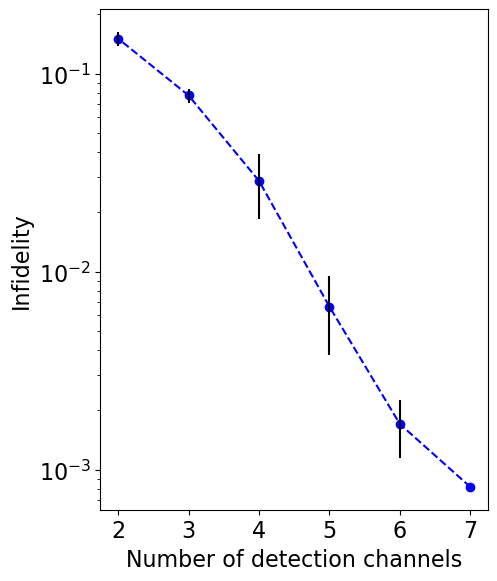

In [12]:
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

plt.figure(figsize=(5,6.5))

plt.plot(np.linspace(7,2,6), 1-fidelity_subset_means, color="blue", linestyle="--")
plt.scatter(np.linspace(7,2,6), 1-fidelity_subset_means, color="blue")
plt.errorbar(np.linspace(7,2,6), 1-fidelity_subset_means, yerr=fidelity_subset_stds, fmt='None', color="black")
plt.yscale("log")
plt.xlabel("Number of detection channels")
plt.ylabel("Infidelity")
plt.xticks(np.linspace(7,2,6))

plt.show()